In [1]:
from glob import glob
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

In [3]:
# Function allows me to return the intersection of a list of values and
# the columns of a dataframe, either as a new list of values, or the
# dataframe represeting the selected columns.
def safe_select(df, cols, columns=True):
    try:
        if type(cols)==str:
            cols=[cols]
        sel_col = df.columns[df.columns.isin(cols)]
        
        if columns==False:
            results = df
        else: results = sel_col
    except Exception as e:
        print(e)
        results = None
    finally:
        return(results)

# Allows me to drop a column if a dataframe has it, otherwise
# returning the original dataset.
def safe_drop(df, istr):
    try:
        if sum(df.columns.isin([istr]))>0:
            results = df.drop(istr, axis=1)
        else: results = df
    except Exception as e:
        print(e)
        results=None
    finally:
        return(results)

In [4]:
os.chdir(glob('H:/Documents/Training/Thinkful/Lender*')[0])

dfile = max(glob('*.csv'))

In [5]:
d = pd.read_csv(dfile, encoding='utf-8')
d = d.iloc[:-2,]
# d.iloc[:, [0, 19, 55]].head()

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Tracking tranformations and other information about fields in dataset
I don't know if there's a better way to do this, but I like to create a 'metadata' table to track basic information, like number of null values, levels, and object type. Later I can also do things like track which columns to drop, and how to transform fields. There might be other ways to do this book keeping, but this makes sense to me.

In [6]:
# We will evaluate the simplicity of a random forest using runtime.
# To evaluate runtime, we need a way to return the difference between
# start and end times.
# perf_counter is recommended for Python 3 running on Windows over
# time.time--possibly better for Linus?--and time.clock, that was
# deprecated as of Python 3 and will be removed in Python 3.8.
from time import perf_counter

start = perf_counter()
md = pd.DataFrame({'nulls': d.apply(lambda x: sum(x.isna())),
                  'dtype': d.dtypes,
                  'levels': d.apply(lambda x: len(x.drop_duplicates()))})
print(perf_counter()-start)
del start

27.019995881000003


## Data cleaning
As the guided example mentioned, there are a number of variables with a prohibitive number of levels to feasibly shove into a random forest and expect the kernel to not crash. Luckily, closer examination reveals several of the fields of dtype object with more than 20 levels as either being dates formatted as strings, percents, unique IDs, or text that would have to be mined to be meaningful. The two variables I don't know how to deal with are zip code and employment title. I'd be interested to see if either has a significant impact on our loan model. For a first pass I'm going to convert zip code to a number and drop job titles.

### Date, percent, null, and fields I'm not going to deal with in this round
Date variables can be identified by their containing "date", starting with "last" or "earliest", or ending with "_d". The actual field will be converted with a function I wrote that returns null values if the field cannot be converted to a date. 

Fields representing percentages contain the percent symbol. I converted these with a function I wrote which removes the "%", strips any whitespace on the ends of the string, converts the number to a float, and divides by zero.

Finally, there are several fields I'm going to drop, either because they simply have too many null values, they are unique identifiers and therefore not true indicator variales, or because they have more than 50 levels and no clear compression method. For example, there is a description text field for each record which would have to be mined using NLP methods I don't currently know. The fields that I am dropping--at least for now--are:
- Job title (emp_title);
- Record identifier (id); and
- Description (desc).

#### Flagging date, percent, and misc columns

In [7]:
# This whole block of code identifies fields in the metadata table. The next
# chunk of code will actually transform the different columns
trans_desc_text = {'pct': 'Initial representation included percent symbol. Symbol was stripped and figures were converted to numbers then divided by 100',
                  'date': 'Convert to date if not null. If value is null, return null (np.nan). Error handling also returns original entry.',
                  'prohibit_levels': 'Might be able to extract other kinds of lower dimensional features.'}

# md[['trans_desc', 'trans', 'drop_fld']] = np.nan

# Transforming fields that represent dates
md.loc[(md.index.str.contains('earli|last|date|(_d$)', regex=True)) &
       (md['dtype']=='object'), 'trans_desc'] = trans_desc_text['date']
md.loc[(md.index.str.contains('earli|last|date|(_d$)', regex=True)) &
       (md['dtype']=='object'), 'trans'] = 'date'

# Transforming fields that represent percentages
md.loc[['int_rate', 'revol_util'], 'trans'] = 'pct'
md.loc[['int_rate', 'revol_util'], 'trans_desc'] = trans_desc_text['pct']

# Dropping fields that have a lot of levels and are either unique IDs or
# for which there is no clearly superior way to compress.
md.loc['emp_title', 'trans_desc'] = trans_desc_text['prohibit_levels']
md.loc[['emp_title', 'desc', 'id'], 'drop_fld'] = 1
md.loc[(md.dtype=='object') & (md.levels>20)].sort_values('levels', ascending=False)

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  del sys.path[0]


,nulls,dtype,levels,trans_desc,trans,drop_fld
emp_title,23874,object,120813,Might be able to extract other kinds of lower ...,NaN,1.0
revol_util,162,object,1212,Initial representation included percent symbol...,pct,NaN
zip_code,0,object,914,NaN,NaN,NaN
earliest_cr_line,0,object,668,"Convert to date if not null. If value is null,...",date,NaN
int_rate,0,object,111,Initial representation included percent symbol...,pct,NaN
last_credit_pull_d,7,object,54,"Convert to date if not null. If value is null,...",date,NaN
last_pymnt_d,294,object,53,"Convert to date if not null. If value is null,...",date,NaN
addr_state,0,object,49,NaN,NaN,NaN
settlement_date,409400,object,49,"Convert to date if not null. If value is null,...",date,NaN
debt_settlement_flag_date,409400,object,46,"Convert to date if not null. If value is null,...",date,NaN


#### Transforming date, percent, and misc columns
First I wrote two functions to convert date and percent columns formatted as strings to date and decimal formats respectively. While they return NaN if an entry has raised an error in order to allow the computations to continue, they do print both the error message and the value that raised the error to aid in debugging.

In [8]:
# Transform date columns
from datetime import datetime

# Transforms date columns formatted as strings to date format
# Except it turns out I didn't need to write this at all since
# there's already a panda "to_datetime" function. Oh well.
def base_to_date(x):
    try:
        interim = pd.to_datetime(x, format='%b-%Y') - datetime.strptime('1970-01-01', '%Y-%m-%d')
        result = pd.Series(interim).apply(lambda x: x.days)
    except Exception as e:
        print(e)
        result = x
    finally:
        return(result)

def to_date(df):
    dt_flds = md.loc[md.trans=='date'].index
    results = df.copy()
    results.loc[:, dt_flds] = results.loc[:, dt_flds].apply(base_to_date)
    return(results)

d_dt = to_date(d)

In [9]:
# Transform percent columns
# Converts fields representing percentages to decimal
def base_pc_convert(x):
    try:
        vec = pd.to_numeric(x.str.replace('%', '').str.strip())
        results = vec/100
    except Exception as e:
        print(e)
        print(x)
        results = x
    finally:
        return(results)

def pc_convert(df):
    try:
        pc_flds = safe_select(df, md.loc[md.trans=='pct'].index)
        results = df.copy()
        if len(pc_flds)>0:
            
            results.loc[:, pc_flds] = results.loc[:, pc_flds].apply(base_pc_convert)
    except Exception as e:
        print(e)
        results = df
    finally:
        return(results)

d_pc_dt = pc_convert(d_dt)

### Converting sub-grade
According to the documentation, sub-grade levels are completely ordinal with 35 levels. For my purposes this seems continuous enough for me to consider them continuous. However, not all possible subgroups are defined. Therefore, I will define the levels and their corresponding values explicitly. For now I'll leave in the grade variable as well, even though sub-grade contains all the grade information.

Information about loan sub-grades can be found on the Lender Club website: https://www.lendingclub.com/foliofn/rateDetail.action

In [10]:
from sklearn.preprocessing import LabelEncoder as le
from itertools import product
from functools import reduce

def subgrade_convert(df):
    try:
        df = safe_drop(df, 'sub_grade_num')
        ks = pd.Series(product(['A', 'B', 'C', 'D', 'E' ,'F', 'G'], np.arange(6)[1:]))\
            .apply(lambda x: '{0}{1}'.format(x[0], x[1]))
        sub_grade_num = pd.DataFrame({'sub_grade': ks, 'sub_grade_num': np.arange(len(ks))})

        results = pd.merge(df, sub_grade_num, how='left', left_on='sub_grade', right_on='sub_grade')\
            .drop(columns = 'sub_grade')
    
    except Exception as e:
        print(e)
        results = df
    finally:
        return(results)
    

# finally:
#     check = sum(dpop.columns.str.contains('sub_grade_num'))
#     if check>0 & sum(dpop.sub_grade_num.isna())<dpop.shape[0]:
#         print('Sub-grade field has been successfully converted.')
#     else:
#         print('Looks like something went wrong.')

d3 = subgrade_convert(d_pc_dt)

### Cleaning title variable
The titles fall into the 10 standard categories with a handful of outliers that were clearly named by the recipients ("new kitchen for momma!" for example). This can be illustrated by looking at the level frequencies.

In [11]:
d.title.value_counts()

Debt consolidation                         249926
Credit card refinancing                    102056
Home improvement                            25264
Other                                       19179
Major purchase                               7434
Medical expenses                             3926
Car financing                                3475
Business                                     3357
Moving and relocation                        2422
Vacation                                     2246
Home buying                                  1440
Green loan                                    223
Paying off higher interest cards & auto         1
Simple Loan Until Contract Is Completed         1
Trying to come back to reality!                 1
DebtC                                           1
SAVE                                            1
New Baby and New House (CC Consolidate)         1
Credit Card/Auto Repair                         1
odymeds                                         1


Where I could I matched custom titles to the following standard titles:
- Business
- Car financing
- Credit card refinancing
- Debt consolidation
- Green loan
- Home buying
- Major purchase
- Medical expenses
- Moving and relocation
- Vacation

The titles I didn't immediately understand how to categorize I left blank, since random forrest can deal with blank values.

In [12]:
# Identifying the standard title categories
title_standard = d.title.value_counts()
title_standard = title_standard.loc[title_standard>200]

# Mapping custom title categories to standard title categories
data = [['Credit Card/Auto Repair', 'Credit card refinancing'],
        ['Paying off higher interest cards & auto', 'Debt consolidation'],
        ['new kitchen for momma!', 'Home improvement'],
        ['Simple Loan Until Contract Is Completed', 'Other'],
        ['New Baby and New House (CC Consolidate)', 'Debt consolidation'],
        ['Pay off Lowes Card', 'Credit card refinancing'],
        ['odymeds', 'Medical expenses'],
        ['Prescription Drug and Medical Costs', 'Medical expenses'],
        ['DebtC', 'Debt consolidation'],
        ['SAVE', 'Other'],
        ['Student Loan', 'Other'],
        ['Learning and training', 'Other'],
       ]

new_titles = pd.DataFrame(data, columns=['title', 'title_stndrd'])

In [13]:
# Transforming the actual title field
d4 = pd.merge(d3, new_titles, how='left', left_on='title', right_on='title')
d4.loc[d4.title.isin(title_standard.index), 'title_stndrd'] = d4.loc[d4.title.isin(title_standard.index), 'title']

# Alternate Model 3
The specifications were to develop a model with a minimum number of features and information that still achieves a 90% accuracy. For convenience I'm going to exclude joint loans because they would require a considerable amount of thought to combine fields. Furthermore, I looked through the definition of the variables available and settled on the following 20 fields for a first pass:
- Annual income;
- Earliest credit line;
- Home ownership at the time of the loan application;
- Initial list status;
- Number of credit inquiries in the last 12 months;
- Installment amount when the loan was initially dispersed;
- Loan interest rate;
- Loan issue date;
- Loan amount;
- The number of open credit lines in the borrower's name;
- Percent of all bankcard accounts > 75% of the limit;
- Number of derogatory public records;
- Loan sub-grade;
- Number of derogatory public records; and
- Borrower zip code.

I arrived at this list by grouping variables and choosing one representative in each group. For example, a number of fields asked questions about the number of current or historical credit lines that had been opened for the borrower. I chose to include only one of these--the number of open credit lines in the borrower's name.

## Data cleaning

In [ ]:
# Filtering out joint application types
try:
    del X3
except Exception as e:
    print(e)

finally:
    m3_flds = ['annual_inc', 'earliest_cr_line',
               'home_ownership', 'inq_last_12m', 'installment', 
               'int_rate', 'loan_amnt', 'mo_sin_rcnt_tl', 
               'open_acc', 'percent_bc_gt_75', 
               'pub_rec', 'sub_grade_num', 'tax_liens', 'tot_hi_cred_lim', 
               'total_acc', 'zip_code']
    m3 = dpop.loc[dpop.application_type=='Individual', m3_flds+['loan_status']]


### Convert zip code to numeric
I have no idea if this is a good idea or not, but neighborhood has historically been significant in denying individuals access to wealth and credit. I'm interested to see if it's an important feature. Mostly, I have no idea if turning the first three digits into numeric values is actually going to be helpful since really these are categorical fields. However, numeric values tend to imply two locations are closer than disparate numbers--to a point, anyway.

In [ ]:
m3.loc[:, 'zip_code'] = pd.to_numeric(m3.zip_code.str.strip('xx'))

### Covert datetime to numeric
Apparently random forrest can't handle datetime objects, so I need to convert the earliest credit line field to the number of days since epoch.

In [ ]:
m3.loc[:, 'earliest_cr_line'] = (m3.earliest_cr_line - np.datetime64('1970-01-01')).apply(lambda x: x.days)

## Modeling

In [ ]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

m3.dropna(inplace=True)

y3 = m3.loan_status
X3 = m3.drop('loan_status', axis=1)
X3 = pd.get_dummies(X3)

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X3, y3, cv=10)

That's not exactly 90%. For the next model I'll shove everything non payment related back in and look at the relative importance of different features.

# Alternate Model 4: Everything non-payment related
The following variables are included in the model:
- addr_state
- all_util
- annual_inc
- annual_inc_joint
- application_type
- avg_cur_bal
- bc_util
- chargeoff_within_12_mths
- collections_12_mths_ex_med
- dti
- dti_joint
- earliest_cr_line
- emp_length
- funded_amnt
- grade
- home_ownership
- il_util
- initial_list_status
- inq_fi
- inq_last_12m
- inq_last_6mths
- installment
- int_rate
- issue_d
- loan_amnt
- max_bal_bc
- mo_sin_old_il_acct
- mo_sin_old_rev_tl_op
- mo_sin_rcnt_rev_tl_op
- mo_sin_rcnt_tl
- mort_acc
- mths_since_last_major_derog
- mths_since_last_record
- mths_since_rcnt_il
- mths_since_recent_bc
- mths_since_recent_bc_dlq
- mths_since_recent_inq
- next_pymnt_d
- num_accts_ever_120_pd
- num_actv_bc_tl
- num_actv_rev_tl
- num_bc_sats
- num_bc_tl
- num_il_tl
- num_op_rev_tl
- num_rev_accts
- num_rev_tl_bal_gt_0
- num_sats
- num_tl_120dpd_2m
- num_tl_30dpd
- num_tl_90g_dpd_24m
- num_tl_op_past_12m
- open_acc
- open_acc_6m
- open_act_il
- open_il_12m
- open_il_24m
- open_rv_12m
- open_rv_24m
- pct_tl_nvr_dlq
- percent_bc_gt_75
- policy_code
- pub_rec
- pub_rec_bankruptcies
- purpose
- tax_liens
- term
- title
- tot_coll_amt
- tot_cur_bal
- tot_hi_cred_lim
- total_acc
- total_bal_il
- total_bc_limit
- total_cu_tl
- total_il_high_credit_limit
- verification_status
- zip_code

## Data Cleaning
### Dropping Payment-Related Fields
One use case is using a predictive model as a decision aid for loan issuers. Therefore, I took the assignment constraints as meaning that I needed to exclude all fields that would not be available when an individual is applying for a loan. I did fudge a little

In [33]:
npay_flds = ['addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'bc_util', 'desc', 'disbursement_method', 'dti', 'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'id', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'member_id', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'next_pymnt_d', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'percent_bc_gt_75', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'sec_app_chargeoff_within_12_mths ', 'sec_app_collections_12_mths_ex_med ', 'sec_app_earliest_cr_line ', 'sec_app_fico_range_high ', 'sec_app_fico_range_low ', 'sec_app_inq_last_6mths ', 'sec_app_mort_acc ', 'sec_app_mths_since_last_major_derog ', 'sec_app_num_rev_accts ', 'sec_app_open_acc ', 'sec_app_open_act_il', 'sub_grade', 'tax_liens', 'tot_coll_amt', 'tot_hi_cred_lim', 'total_acc', 'total_bc_limit', 'total_il_high_credit_limit', 'total_rev_hi_lim ', 'url', 'verification_status', 'verified_status_joint']
npay_flds = pd.Series(npay_flds).drop_duplicates()

m5 = safe_select(d4, npay_flds, columns=False)

In [34]:
m5.shape

(421095, 145)

In [35]:
nulls = m5.apply(lambda x: sum(x.isna())).sort_values(ascending=False)
drop_null = nulls.loc[nulls>132].index
print('Number of columns with more than 132 null values: {0:,}'.format(drop_null.shape[0]))
print('Number of remaining indicator columns: {0}'.format(m5.shape[1] - drop_null.shape[0] - 1))

Number of columns with more than 132 null values: 70
Number of remaining indicator columns: 74


In [36]:
print(m5.shape)

(421095, 145)


In [40]:
m5 = m5.drop(drop_null, axis=1)
m5 = m5.dropna()
# m5 = safe_drop(m5, ['zip_code'])
print(m5.shape)

(421095, 75)


In [42]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import ExtraTreesClassifier as extratc
from sklearn.model_selection import cross_val_score
m5=m5.dropna()
X5 = m5.loc[:, m5.columns.difference(['loan_status'])]
X5 = pd.get_dummies(X5)
y5 = m5.loan_status

In [43]:
X5.shape

(420953, 1091)

In [49]:
forr = rfc()

cross_val_score(forr, X5, y5, cv=5)

C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dmnb4898\miniconda3\envs\Env37\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\dmnb489

array([0.98132884, 0.9838702 , 0.9844639 , 0.98733801, 0.98643496])

In [20]:
X5.shape

(0, 120)

Feature ranking:
1. feature 146 (0.105886)
2. feature 113 (0.079465)
3. feature 112 (0.077442)
4. feature 145 (0.076549)
5. feature 38 (0.067221)
6. feature 59 (0.058586)
7. feature 18 (0.054834)
8. feature 39 (0.050195)
9. feature 114 (0.044334)
10. feature 118 (0.041796)
11. feature 46 (0.041481)
12. feature 56 (0.032238)
13. feature 57 (0.029001)
14. feature 44 (0.028241)
15. feature 115 (0.020434)
16. feature 15 (0.020091)
17. feature 11 (0.020002)
18. feature 5 (0.019650)
19. feature 17 (0.018926)
20. feature 119 (0.014899)
21. feature 19 (0.013329)
22. feature 55 (0.011709)
23. feature 12 (0.010867)
24. feature 176 (0.009082)
25. feature 126 (0.008183)
26. feature 1 (0.005986)
27. feature 117 (0.005046)
28. feature 128 (0.003562)
29. feature 127 (0.003183)
30. feature 20 (0.003142)
31. feature 124 (0.003101)
32. feature 120 (0.002066)
33. feature 14 (0.001998)
34. feature 131 (0.001965)
35. feature 36 (0.001627)
36. feature 174 (0.001560)
37. feature 13 (0.001435)
38. feature 130

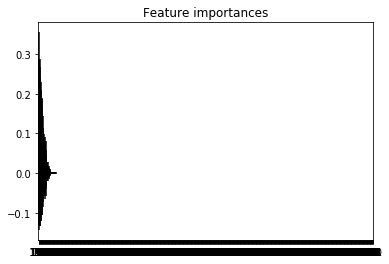

In [45]:
from sklearn.ensemble import ExtraTreesClassifier
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100,
                              max_depth=4)

# X4 = m5.loc[:, m5.columns.difference(['loan_status'])]
# X4 = pd.get_dummies(X4)
# X5 = X4.apply(lambda x: x.astype(float))
# y5 = m5.loan_status

forest.fit(X5, y5)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X5.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X5.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X5.shape[1]), indices)
plt.xlim([-1, X5.shape[1]])
plt.show()

# Alternate Model 5: Strategic feature selection

In [67]:
ref = pd.DataFrame()
ref['importance'] = importances[indices]
ref['index'] = indices
ref['feature'] = X5.columns[indices]
ref = ref.sort_values('importance', ascending=False)

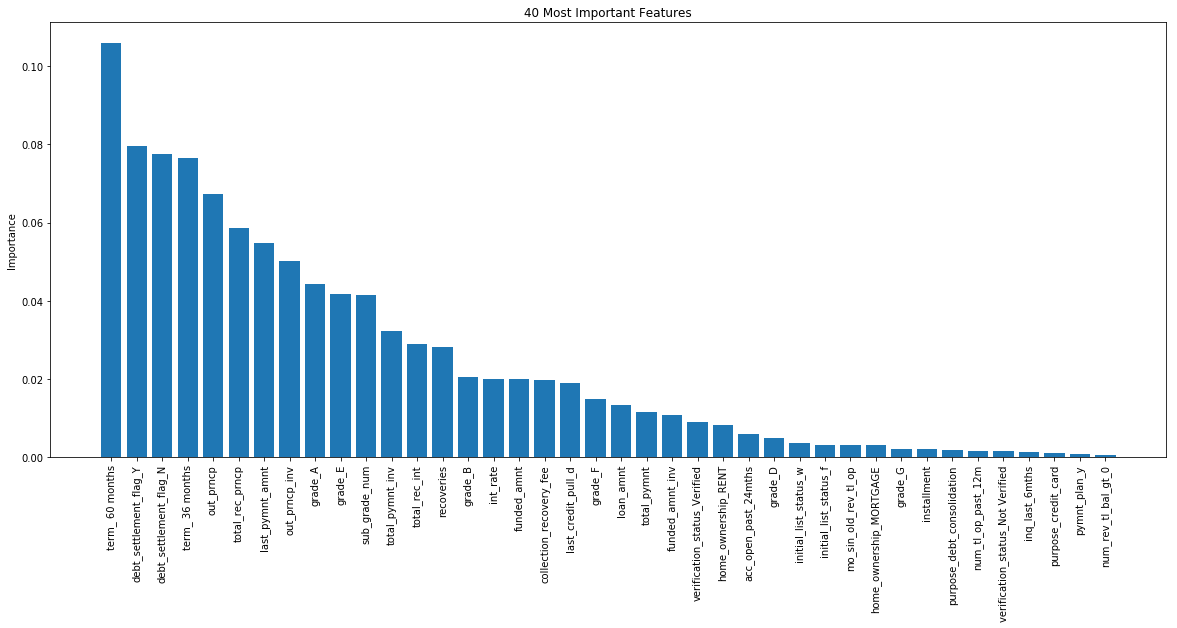

In [73]:
f, ax = plt.subplots(figsize=(20, 8))
ax.bar(ref.feature[:40], ref.importance[:40])
plt.xticks(rotation='vertical')
plt.title('40 Most Important Features')
plt.ylabel('Importance')
plt.show()

In [74]:
ref.feature[:13]

0            term_ 60 months
1     debt_settlement_flag_Y
2     debt_settlement_flag_N
3            term_ 36 months
4                  out_prncp
5            total_rec_prncp
6            last_pymnt_amnt
7              out_prncp_inv
8                    grade_A
9                    grade_E
10             sub_grade_num
11           total_pymnt_inv
12             total_rec_int
Name: feature, dtype: object

It looks like payment variables snuck in and were the most important factors. However, they did not appear to be more imporant than the term length. If I were to do this in earnest I would need to scrub all payment variables.